# Generating window aggregated data

## Imports

In [1]:
import os
import random
import calendar
import datetime
import warnings
import numpy as np
import pandas as pd
from datetime import timedelta
from collections import Counter
from google.cloud import bigquery

from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets

import scipy.stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings("ignore")
tqdm.pandas()

In [2]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Config

In [3]:
# Config

PROJECT_ID = "arpae-prod-ml"

# BigQuery
JOINED_BQ_DATASET = "JOINED_DATA"
JOINED_DATA_TABLE = "ALL_METEO_FEATS_POL_DAT"
B_CODES_TABLE = "B_CODES"

# Ouput
model_output = "models"

## Methods

In [4]:
# Read Methods

def _run_query(client, query):
    df = client.query(query).to_dataframe()
    return df

def min_max_scale(x):
    return (x - x.min()) / (x.max() - x.min())

# 1. Read Data

## 1.1 Config BigQuery

In [5]:
# Setup Client

bq_client = bigquery.Client(project="arpae-prod-ml")
bq_client

## 1.2 Read Tables

In [6]:
# Load B_CODES

sql = f"SELECT * FROM `{PROJECT_ID}.SAMPLE_DATA.{B_CODES_TABLE}` WHERE eligible IS true"
b_codes = _run_query(bq_client, sql)

print(b_codes.shape)
b_codes.head(3)

(33, 3)


var_id                                  var_descr  eligible
0  B48026  Mirtacee_Mirtacee indistinte, POLLEN/M**3      True
1  B48006           Composite_Artemisia, POLLEN/M**3      True
2  B48041     Spore fungine_Stemphylium, POLLEN/M**3      True

In [7]:
# Load all meteo and pollen data

sql = f"""
    SELECT DISTINCT *
    FROM `{PROJECT_ID}.{JOINED_BQ_DATASET}.{JOINED_DATA_TABLE}`
    WHERE pol_var_id IN {tuple(b_codes.var_id)}
    ORDER BY station_id, pol_var_id, date
"""

raw_df = _run_query(bq_client, sql)

print(raw_df.shape)
raw_df.head(3)

(1410777, 33)


station_id        date  B13011_min  B13011_max  B13011_mean  B13011_std  \
0           1  2006-03-01         0.0         0.0          0.0         0.0   
1           1  2006-03-02         0.0         0.0          0.0         0.0   
2           1  2006-03-03         0.0         0.0          0.0         0.0   

   B13011_sum  B14198_min  B14198_max  B14198_mean  ...      arkimet_id  \
0         0.0       -11.0       588.0       138.76  ...  Bologna urbana   
1         0.0        -6.0       351.0        61.56  ...  Bologna urbana   
2         0.0        -5.0       406.0        87.12  ...  Bologna urbana   

   arkimet_lat  arkimet_lon  meteo_id  pol_var_id  pol_value  modified  \
0      44.5008      11.3288     01421      B48001        0.0         1   
1      44.5008      11.3288     01421      B48001        0.0         1   
2      44.5008      11.3288     01421      B48001        0.0         1   

                                   pol_var_descr  week  year  
0  Graminacee_Graminacee indistinte, POLLEN/M**3     9  2006  
1  Graminacee_Graminacee indistinte, POLLEN/M**3     9  2006  
2  Graminacee_Graminacee indistinte, POLLEN/M**3     9  2006  

[3 rows x 33 columns]

___

# 2. Data preprocess

In [8]:
raw_df.drop(["id_gepo", "meteo_id", "modified", "pol_var_descr", "arkimet_id", "arkimet_lat", "arkimet_lon", "year"], axis=1, inplace=True)
print(raw_df.shape)

(1410777, 25)


In [9]:
raw_df.dropna(inplace=True)
print(raw_df.shape)
raw_df.head(3)

(1410290, 25)


station_id        date  B13011_min  B13011_max  B13011_mean  B13011_std  \
0           1  2006-03-01         0.0         0.0          0.0         0.0   
1           1  2006-03-02         0.0         0.0          0.0         0.0   
2           1  2006-03-03         0.0         0.0          0.0         0.0   

   B13011_sum  B14198_min  B14198_max  B14198_mean  ...  TEMP_std  TEMP_sum  \
0         0.0       -11.0       588.0       138.76  ...  7.495332       7.2   
1         0.0        -6.0       351.0        61.56  ...  5.868986       6.3   
2         0.0        -5.0       406.0        87.12  ...  6.505382       8.0   

   PREC  station_lat  station_lon  station_H_piano_strada  station_H_mslm  \
0   0.0      44.4914      11.3694                    80.0           101.0   
1   0.9      44.4914      11.3694                    80.0           101.0   
2   0.0      44.4914      11.3694                    80.0           101.0   

   pol_var_id  pol_value  week  
0      B48001        0.0     9  
1      B48001        0.0     9  
2      B48001        0.0     9  

[3 rows x 25 columns]

In [10]:
raw_df.sort_values(["station_id", "pol_var_id", "date"], inplace=True)

In [11]:
# Convert dates to datetime format
raw_df.date = pd.to_datetime(raw_df.date)

raw_df["month"] = raw_df.date.dt.month
raw_df["week"] = raw_df.date.dt.isocalendar().week
# df["day"] = df.date.dt.day

In [12]:
# Set datetime as index
# raw_df.set_index(["pol_var_id", "station_id", "date"], inplace=True)
raw_df.set_index("date", inplace=True)
raw_df.sort_values(by=["station_id", "pol_var_id", "date"], ascending=True, inplace=True)

raw_df.dropna(inplace=True)
print(raw_df.shape)
raw_df.head(3)

(1410290, 25)


station_id  B13011_min  B13011_max  B13011_mean  B13011_std  \
date                                                                      
2006-03-01           1         0.0         0.0          0.0         0.0   
2006-03-02           1         0.0         0.0          0.0         0.0   
2006-03-03           1         0.0         0.0          0.0         0.0   

            B13011_sum  B14198_min  B14198_max  B14198_mean  B14198_std  ...  \
date                                                                     ...   
2006-03-01         0.0       -11.0       588.0       138.76  200.669770  ...   
2006-03-02         0.0        -6.0       351.0        61.56   98.767015  ...   
2006-03-03         0.0        -5.0       406.0        87.12  133.675702  ...   

            TEMP_sum  PREC  station_lat  station_lon  station_H_piano_strada  \
date                                                                           
2006-03-01       7.2   0.0      44.4914      11.3694                    80.0   
2006-03-02       6.3   0.9      44.4914      11.3694                    80.0   
2006-03-03       8.0   0.0      44.4914      11.3694                    80.0   

            station_H_mslm  pol_var_id  pol_value  week  month  
date                                                            
2006-03-01           101.0      B48001        0.0     9      3  
2006-03-02           101.0      B48001        0.0     9      3  
2006-03-03           101.0      B48001        0.0     9      3  

[3 rows x 25 columns]

___

# 3. Feature process

## 3.1 Adding Seasonal trend as feature

In [13]:
seasonal_feature = "seasonal"
trend_feature = "trend"
resid_feature = "residual"

raw_df[seasonal_feature] = None
raw_df[trend_feature] = None

for (stat_id, specie_id), specie_data in tqdm(raw_df.groupby(["station_id", "pol_var_id"])):
    # Prepare specie data
    specie_data = specie_data.copy()
    specie_data.sort_index(inplace=True)
    specie_pollen = specie_data[["pol_value"]]#.resample("D")#.interpolate()

    # Evaluate seasonal
    # decomposition = seasonal_decompose(specie_pollen.pol_value, period=365, extrapolate_trend=365, model="additive")
    decomposition = seasonal_decompose(specie_pollen.pol_value, period=365, model="additive")
    specie_seasonal = decomposition.seasonal
    specie_trend = decomposition.trend
    specie_resisual = decomposition.resid
    
    mask = (raw_df.station_id == stat_id) & (raw_df.pol_var_id == specie_id)  # get specie mask
    
    # Join seasonal
    specie_seasonal = specie_seasonal.reindex(raw_df.loc[mask].index)  # reindex due to index diff
    raw_df.loc[mask, seasonal_feature] = specie_seasonal.values  # now we can add the seasonal feature
    
    # Join trend
    specie_trend = specie_trend.reindex(raw_df.loc[mask].index)
    raw_df.loc[mask, trend_feature] = specie_trend.values
    
    # Join residual
    specie_resisual = specie_resisual.reindex(raw_df.loc[mask].index)
    raw_df.loc[mask, resid_feature] = specie_resisual.values

raw_df.seasonal = raw_df.seasonal.astype(float)
raw_df.trend = raw_df.trend.astype(float)
raw_df.residual = raw_df.residual.astype(float)

print(raw_df.shape)
print(raw_df.dropna().shape)

  0%|          | 0/363 [00:00<?, ?it/s]

(1410290, 28)
(1278158, 28)


In [14]:
raw_df.dropna(inplace=True)

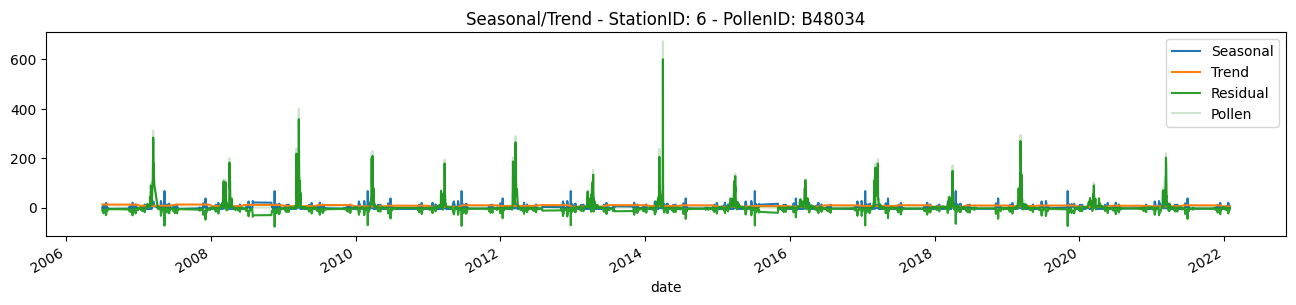

In [15]:
### Verify seasonal
tmp_stid, tmp_polid = raw_df.sample(1).iloc[0][["station_id", "pol_var_id"]].values
tmp_df = raw_df[(raw_df.station_id==tmp_stid) & (raw_df.pol_var_id==tmp_polid)]
tmp_df.seasonal.plot(title=f"Seasonal/Trend - StationID: {tmp_stid} - PollenID: {tmp_polid}", figsize=(16,3), label="Seasonal");
tmp_df.trend.plot(label="Trend");
tmp_df.residual.plot(label="Residual");
tmp_df.pol_value.plot(alpha=.2, c="green", label="Pollen");
plt.legend(loc="upper right");

## 3.2 Creating windows and aggregate data

#### 3.2 Example

In [16]:
date_rng = pd.date_range(start='1/1/2022', end='1/5/2022', freq='D')
date_rng = np.hstack([date_rng, date_rng])
df = pd.DataFrame(date_rng, columns=['date'])
df['station_id'] = ['A']*5 + ['B']*5
df['pol_var_id'] = ['X']*5 + ['Y']*5 #['X']*3 + ['Y']*2 + ['X']*3 + ['Y']*2
df['data1'] = np.random.randint(0,10,size=(len(date_rng)))
df['data2'] = np.random.randint(0,10,size=(len(date_rng)))
df.set_index(['date'], inplace=True)
display(df)

# Sort df
df = df.sample(frac=1).sort_values(["station_id", "pol_var_id", "date"])

# Define aggregation functions and column names
aggregating_functions = {
    "data1": ["max", "min"],
    "data2": [np.median, scipy.stats.skew, scipy.stats.kurtosis],
}

# Group by Station/Pollen
df_rolled = df.groupby(["station_id", "pol_var_id"])

# Apply rolling window
window_day_size = 4
df_rolled = df_rolled.rolling(window=f"{window_day_size}D", min_periods=window_day_size, center=False)

# Apply rolling window and aggregate
df_rolled = df_rolled.agg(aggregating_functions)

# df_rolled.columns = column_names
df_rolled.columns = list(map(lambda c: "_".join(c) if all(c) else c[0], df_rolled.columns))
df_rolled.dropna(inplace=True)
df_rolled.reset_index(inplace=True)
df_rolled.set_index('date', inplace=True)
display(df_rolled)

station_id pol_var_id  data1  data2
date                                          
2022-01-01          A          X      7      3
2022-01-02          A          X      5      4
2022-01-03          A          X      9      4
2022-01-04          A          X      3      0
2022-01-05          A          X      6      4
2022-01-01          B          Y      1      6
2022-01-02          B          Y      7      9
2022-01-03          B          Y      6      3
2022-01-04          B          Y      2      8
2022-01-05          B          Y      1      5

station_id pol_var_id  data1_max  data1_min  data2_median  \
date                                                                   
2022-01-04          A          X        9.0        3.0           3.5   
2022-01-05          A          X        9.0        3.0           4.0   
2022-01-04          B          Y        7.0        1.0           7.0   
2022-01-05          B          Y        7.0        1.0           6.5   

            data2_skew  data2_kurtosis  
date                                    
2022-01-04   -0.957549       -0.851271  
2022-01-05   -1.154701       -0.666667  
2022-01-04   -0.498784       -1.238095  
2022-01-05   -0.186618       -1.604396

In [17]:
# # Group by Station/Pollen
# df_rolled = df_rolled.groupby(["station_id", "pol_var_id"])

# # Apply rolling window
# window_day_size = 30
# df_rolled = df_rolled.rolling(window=f"{window_day_size}D", min_periods=window_day_size, center=False)

# # Apply rolling window and aggregate
# df_rolled = df_rolled.agg(aggregating_functions)

# # df_rolled.columns = column_names
# df_rolled.columns = list(map(lambda c: "_".join(c) if all(c) else c[0], df_rolled.columns))
# df_rolled.dropna(inplace=True)
# df_rolled.reset_index(inplace=True)
# df_rolled.set_index('date', inplace=True)

# print(df_rolled.shape)
# display(df_rolled)

In [18]:
# # Group by Station/Pollen
# df_grouped = df_dataset.groupby(["station_id", "pol_var_id"])

# df_rolled = []
# for (station_id, pol_var_id), group in tqdm(df_grouped):
#     # Apply rolling window
#     group = group.rolling(window=f"{window_day_size}D", min_periods=window_day_size, center=False)

#     # Apply rolling window and aggregate
#     group = group.agg(aggregating_functions)

#     # df_rolled.columns = column_names
#     group.columns = list(map(lambda c: "_".join(c) if all(c) else c[0], group.columns))
#     group.dropna(inplace=True)
#     group.reset_index(inplace=True)
#     group.set_index('date', inplace=True)
    
#     #group["station_id"] = station_id
#     #group["pol_var_id"] = pol_var_id
#     group.insert(0, "pol_var_id", pol_var_id)
#     group.insert(0, "station_id", station_id)

#     #print(group.shape)
#     #display(group)
#     df_rolled.append(group)

# df_rolled = pd.concat(df_rolled)
# df_rolled

### Sort dataset

In [19]:
df_dataset = raw_df.sort_values(["station_id", "pol_var_id", "date"]).copy()

print(df_dataset.shape)
df_dataset.head(3)

(1278158, 28)


station_id  B13011_min  B13011_max  B13011_mean  B13011_std  \
date                                                                      
2006-08-30           1         0.0         1.2     0.029508    0.146974   
2006-08-31           1         0.0         1.2     0.009836    0.108643   
2006-09-01           1         0.0         0.0     0.000000    0.000000   

            B13011_sum  B14198_min  B14198_max  B14198_mean  B14198_std  ...  \
date                                                                     ...   
2006-08-30         3.6       -10.0       749.0       227.92  275.519346  ...   
2006-08-31         1.2        -7.0       789.0       251.60  304.403926  ...   
2006-09-01         0.0        -8.0       766.0       241.48  293.077510  ...   

            station_lon  station_H_piano_strada  station_H_mslm  pol_var_id  \
date                                                                          
2006-08-30      11.3694                    80.0           101.0      B48001   
2006-08-31      11.3694                    80.0           101.0      B48001   
2006-09-01      11.3694                    80.0           101.0      B48001   

            pol_value  week  month  seasonal      trend  residual  
date                                                               
2006-08-30       4.30    35      8 -0.781629  14.214740 -9.133111  
2006-08-31       4.73    35      8 -2.032752  14.244192 -7.481440  
2006-09-01       5.59    35      9 -5.355587  14.287781 -3.342194  

[3 rows x 28 columns]

### Generating aggregated windows only on consecutive days
#### Avoiding generating windows where there's some day missing.
* (e.g. Station B48001 on Station 1 goes from 2006-11-30 to 2007-03-01)


In [20]:
def consecutive_agg(index):
    date_diff = (pd.Series(index).diff() != pd.Timedelta(days=1)).cumsum()
    return date_diff.values

date_diffs = df_dataset.groupby(["station_id", "pol_var_id"]).progress_apply(lambda group: consecutive_agg(group.index))
date_diffs = np.hstack(date_diffs)
df_dataset["date_diff"] = date_diffs

# df_dataset[df_dataset.date_diff != df_dataset.date_diff.shift(1)][["station_id", "pol_var_id", "date_diff"]]
print(df_dataset.shape)
df_dataset.head(3)

  0%|          | 0/363 [00:00<?, ?it/s]

(1278158, 29)


station_id  B13011_min  B13011_max  B13011_mean  B13011_std  \
date                                                                      
2006-08-30           1         0.0         1.2     0.029508    0.146974   
2006-08-31           1         0.0         1.2     0.009836    0.108643   
2006-09-01           1         0.0         0.0     0.000000    0.000000   

            B13011_sum  B14198_min  B14198_max  B14198_mean  B14198_std  ...  \
date                                                                     ...   
2006-08-30         3.6       -10.0       749.0       227.92  275.519346  ...   
2006-08-31         1.2        -7.0       789.0       251.60  304.403926  ...   
2006-09-01         0.0        -8.0       766.0       241.48  293.077510  ...   

            station_H_piano_strada  station_H_mslm  pol_var_id  pol_value  \
date                                                                        
2006-08-30                    80.0           101.0      B48001       4.30   
2006-08-31                    80.0           101.0      B48001       4.73   
2006-09-01                    80.0           101.0      B48001       5.59   

            week  month  seasonal      trend  residual  date_diff  
date                                                               
2006-08-30    35      8 -0.781629  14.214740 -9.133111          1  
2006-08-31    35      8 -2.032752  14.244192 -7.481440          1  
2006-09-01    35      9 -5.355587  14.287781 -3.342194          1  

[3 rows x 29 columns]

In [21]:
# df_dataset[df_dataset.date_diff != df_dataset.date_diff.shift(1)][["station_id", "pol_var_id", "date_diff"]]

In [22]:
# df_dataset[(df_dataset.station_id==13) & (df_dataset.pol_var_id == "B48045")].loc["2020-08-01":"2020-08-20"]

### Parameters and aggregating functions

In [23]:
### Window size to aggregate, in days
window_day_size = 7

In [24]:
### Functions to evaluate on each feature

def prev_1(x): return x[-1]
def prev_2(x): return x[-2]
def prev_3(x): return x[-3]
def prev_4(x): return x[-4]
def prev_5(x): return x[-5]
def prev_6(x): return x[-6]
def prev_7(x): return x[-7]

aggregating_functions = {
    "B13011_min": [np.min],
    "B13011_max": [np.max],
    "B13011_mean": [np.mean],
    "B13011_std": [np.mean],
    "B13011_sum": [np.sum],
    "B14198_min": [np.min],
    "B14198_max": [np.max],
    "B14198_mean": [np.mean],
    "B14198_std": [np.mean],
    "B14198_sum": [np.sum],
    "TEMP_min": [np.min],
    "TEMP_max": [np.max],
    "TEMP_mean": [np.mean],
    "TEMP_std": [np.mean],
    "TEMP_sum": [np.sum],
    "station_lat": [np.max],
    "station_lon": [np.max],
    "station_H_piano_strada": [np.max],
    "station_H_mslm": [np.max],
    "seasonal": [np.mean, prev_1],
    "trend": [np.mean, prev_1],
    "residual": [np.mean, prev_1],
    "week": [np.max],
    "PREC": [np.min, np.mean, np.std, np.median, np.max, scipy.stats.skew, scipy.stats.kurtosis],
    "pol_value": [np.min, np.mean, np.std, np.median, np.max, scipy.stats.skew, scipy.stats.kurtosis, prev_1, prev_2, prev_3, prev_4, prev_5, prev_6, prev_7],
}

### Aggregate features on each group

In [25]:
%%time
def get_window_features(group):
    pol_var_id, station_id = group[["pol_var_id", "station_id"]].iloc[0].values

    # Apply rolling window
    group = group.rolling(window=f"{window_day_size}D", min_periods=window_day_size, center=False)

    # Apply rolling window and aggregate
    group = group.agg(aggregating_functions)
    group.dropna(how="all", inplace=True)

    # df_rolled.columns = column_names
    group.columns = list(map(lambda c: "_".join(c) if all(c) else c[0], group.columns))
    group.reset_index(inplace=True)
    group.set_index('date', inplace=True)
    group.insert(0, "pol_var_id", pol_var_id)
    group.insert(0, "station_id", station_id)
    return group

# Evaluate window features
df_grouped = df_dataset.groupby(["station_id", "pol_var_id", "date_diff"])
df_rolled = df_grouped.parallel_apply(get_window_features)

# Reformat dataset
df_rolled.fillna(0, inplace=True)
df_rolled.drop(["station_id", "pol_var_id"], axis=1, inplace=True)
df_rolled.sort_values(["station_id", "pol_var_id", "date"], inplace=True)
df_rolled.reset_index(inplace=True)
df_rolled.set_index("date", inplace=True)
df_rolled.station_id = df_rolled.station_id.astype(int)

print(df_rolled.shape)
df_rolled.head(5)

(1192406, 50)
CPU times: user 29.8 s, sys: 5.36 s, total: 35.2 s
Wall time: 18min 52s


station_id pol_var_id  date_diff  B13011_min_amin  \
date                                                            
2006-09-05           1     B48001          1              0.0   
2006-09-06           1     B48001          1              0.0   
2006-09-07           1     B48001          1              0.0   
2006-09-08           1     B48001          1              0.0   
2006-09-09           1     B48001          1              0.0   

            B13011_max_amax  B13011_mean_mean  B13011_std_mean  \
date                                                             
2006-09-05              1.2          0.005621         0.036517   
2006-09-06              1.2          0.001405         0.015520   
2006-09-07              0.0          0.000000         0.000000   
2006-09-08              2.0          0.012178         0.039378   
2006-09-09              5.2          0.024356         0.134097   

            B13011_sum_sum  B14198_min_amin  B14198_max_amax  ...  \
date                                                          ...   
2006-09-05             4.8            -10.0            789.0  ...   
2006-09-06             1.2            -10.0            789.0  ...   
2006-09-07             0.0            -10.0            766.0  ...   
2006-09-08            10.4            -10.0            759.0  ...   
2006-09-09            20.8            -10.0            761.0  ...   

            pol_value_amax  pol_value_skew  pol_value_kurtosis  \
date                                                             
2006-09-05            5.59       -0.068805           -1.351947   
2006-09-06            5.59        0.247239           -1.593525   
2006-09-07            5.59        0.683507           -1.188383   
2006-09-08            5.16        1.283251            0.332357   
2006-09-09            5.16        1.022511           -0.492541   

            pol_value_prev_1  pol_value_prev_2  pol_value_prev_3  \
date                                                               
2006-09-05              5.16              3.01              3.01   
2006-09-06              3.01              5.16              3.01   
2006-09-07              2.58              3.01              5.16   
2006-09-08              2.58              2.58              3.01   
2006-09-09              4.30              2.58              2.58   

            pol_value_prev_4  pol_value_prev_5  pol_value_prev_6  \
date                                                               
2006-09-05              3.87              5.59              4.73   
2006-09-06              3.01              3.87              5.59   
2006-09-07              3.01              3.01              3.87   
2006-09-08              5.16              3.01              3.01   
2006-09-09              3.01              5.16              3.01   

            pol_value_prev_7  
date                          
2006-09-05              4.30  
2006-09-06              4.73  
2006-09-07              5.59  
2006-09-08              3.87  
2006-09-09              3.01  

[5 rows x 50 columns]

### Add next day features back, as label

In [26]:
df_rolled.reset_index(inplace=True)

pol_value_label = pd.merge(df_rolled, raw_df.reset_index(), on=["station_id", "pol_var_id", "date"], how="inner").pol_value
season_label = pd.merge(df_rolled, raw_df.reset_index(), on=["station_id", "pol_var_id", "date"], how="inner").seasonal
trend_label = pd.merge(df_rolled, raw_df.reset_index(), on=["station_id", "pol_var_id", "date"], how="inner").trend
residual_label = pd.merge(df_rolled, raw_df.reset_index(), on=["station_id", "pol_var_id", "date"], how="inner").residual

df_rolled["pol_value_label"] = pol_value_label.values
df_rolled["season_label"] = season_label.values
df_rolled["trend_label"] = trend_label.values
df_rolled["residual_label"] = residual_label.values

df_rolled.set_index("date", inplace=True)
print(df_rolled.shape)
df_rolled.head(5)

(1192406, 54)


station_id pol_var_id  date_diff  B13011_min_amin  \
date                                                            
2006-09-05           1     B48001          1              0.0   
2006-09-06           1     B48001          1              0.0   
2006-09-07           1     B48001          1              0.0   
2006-09-08           1     B48001          1              0.0   
2006-09-09           1     B48001          1              0.0   

            B13011_max_amax  B13011_mean_mean  B13011_std_mean  \
date                                                             
2006-09-05              1.2          0.005621         0.036517   
2006-09-06              1.2          0.001405         0.015520   
2006-09-07              0.0          0.000000         0.000000   
2006-09-08              2.0          0.012178         0.039378   
2006-09-09              5.2          0.024356         0.134097   

            B13011_sum_sum  B14198_min_amin  B14198_max_amax  ...  \
date                                                          ...   
2006-09-05             4.8            -10.0            789.0  ...   
2006-09-06             1.2            -10.0            789.0  ...   
2006-09-07             0.0            -10.0            766.0  ...   
2006-09-08            10.4            -10.0            759.0  ...   
2006-09-09            20.8            -10.0            761.0  ...   

            pol_value_prev_2  pol_value_prev_3  pol_value_prev_4  \
date                                                               
2006-09-05              3.01              3.01              3.87   
2006-09-06              5.16              3.01              3.01   
2006-09-07              3.01              5.16              3.01   
2006-09-08              2.58              3.01              5.16   
2006-09-09              2.58              2.58              3.01   

            pol_value_prev_5  pol_value_prev_6  pol_value_prev_7  \
date                                                               
2006-09-05              5.59              4.73              4.30   
2006-09-06              3.87              5.59              4.73   
2006-09-07              3.01              3.87              5.59   
2006-09-08              3.01              3.01              3.87   
2006-09-09              5.16              3.01              3.01   

            pol_value_label  season_label  trend_label  residual_label  
date                                                                    
2006-09-05             5.16     -4.572541    14.466849       -4.734309  
2006-09-06             3.01     -2.230027    14.478630       -9.238603  
2006-09-07             2.58     -5.474573    14.492767       -6.438194  
2006-09-08             2.58     -4.067300    14.498658       -7.851357  
2006-09-09             4.30     -4.810135    14.503370       -5.393235  

[5 rows x 54 columns]

### Shift pollen value to predict by one day

In [27]:
def shift_pollen(df):
    ### Applying shift here
    df["pol_value_label"] = df.groupby(["station_id", "pol_var_id", "date_diff"])["pol_value_label"].shift(-1)
    df["season_label"] = df.groupby(["station_id", "pol_var_id", "date_diff"])["season_label"].shift(-1)
    df["trend_label"] = df.groupby(["station_id", "pol_var_id", "date_diff"])["trend_label"].shift(-1)
    df["residual_label"] = df.groupby(["station_id", "pol_var_id", "date_diff"])["residual_label"].shift(-1)
    return df

df_rolled = shift_pollen(df_rolled)
print(df_rolled.shape)

df_rolled.dropna(inplace=True) # Here we'll lose N values, one for each pair station/pollen/date_diff, because of the shift
print(df_rolled.shape)

df_rolled.head(3)

(1192406, 54)
(1178983, 54)


station_id pol_var_id  date_diff  B13011_min_amin  \
date                                                            
2006-09-05           1     B48001          1              0.0   
2006-09-06           1     B48001          1              0.0   
2006-09-07           1     B48001          1              0.0   

            B13011_max_amax  B13011_mean_mean  B13011_std_mean  \
date                                                             
2006-09-05              1.2          0.005621         0.036517   
2006-09-06              1.2          0.001405         0.015520   
2006-09-07              0.0          0.000000         0.000000   

            B13011_sum_sum  B14198_min_amin  B14198_max_amax  ...  \
date                                                          ...   
2006-09-05             4.8            -10.0            789.0  ...   
2006-09-06             1.2            -10.0            789.0  ...   
2006-09-07             0.0            -10.0            766.0  ...   

            pol_value_prev_2  pol_value_prev_3  pol_value_prev_4  \
date                                                               
2006-09-05              3.01              3.01              3.87   
2006-09-06              5.16              3.01              3.01   
2006-09-07              3.01              5.16              3.01   

            pol_value_prev_5  pol_value_prev_6  pol_value_prev_7  \
date                                                               
2006-09-05              5.59              4.73              4.30   
2006-09-06              3.87              5.59              4.73   
2006-09-07              3.01              3.87              5.59   

            pol_value_label  season_label  trend_label  residual_label  
date                                                                    
2006-09-05             3.01     -2.230027    14.478630       -9.238603  
2006-09-06             2.58     -5.474573    14.492767       -6.438194  
2006-09-07             2.58     -4.067300    14.498658       -7.851357  

[3 rows x 54 columns]

## 3.3 One-hot encode features

In [28]:
def one_hot_encode_feat(df, columns):
    for col in columns:
        # Encode feature
        var_enc = pd.get_dummies(df[col], prefix=col)
        var_enc = var_enc.astype(int)
        # Add one-hot encoded values to original dataframe
        df = pd.concat([df, var_enc], axis=1)
    return df

columns_to_encode = ["station_id", "pol_var_id"]
df_rolled = one_hot_encode_feat(df_rolled, columns_to_encode)

print(df_rolled.shape)
df_rolled.head(5)

(1178983, 98)


station_id pol_var_id  date_diff  B13011_min_amin  \
date                                                            
2006-09-05           1     B48001          1              0.0   
2006-09-06           1     B48001          1              0.0   
2006-09-07           1     B48001          1              0.0   
2006-09-08           1     B48001          1              0.0   
2006-09-09           1     B48001          1              0.0   

            B13011_max_amax  B13011_mean_mean  B13011_std_mean  \
date                                                             
2006-09-05              1.2          0.005621         0.036517   
2006-09-06              1.2          0.001405         0.015520   
2006-09-07              0.0          0.000000         0.000000   
2006-09-08              2.0          0.012178         0.039378   
2006-09-09              5.2          0.024356         0.134097   

            B13011_sum_sum  B14198_min_amin  B14198_max_amax  ...  \
date                                                          ...   
2006-09-05             4.8            -10.0            789.0  ...   
2006-09-06             1.2            -10.0            789.0  ...   
2006-09-07             0.0            -10.0            766.0  ...   
2006-09-08            10.4            -10.0            759.0  ...   
2006-09-09            20.8            -10.0            761.0  ...   

            pol_var_id_B48032  pol_var_id_B48033  pol_var_id_B48034  \
date                                                                  
2006-09-05                  0                  0                  0   
2006-09-06                  0                  0                  0   
2006-09-07                  0                  0                  0   
2006-09-08                  0                  0                  0   
2006-09-09                  0                  0                  0   

            pol_var_id_B48036  pol_var_id_B48037  pol_var_id_B48038  \
date                                                                  
2006-09-05                  0                  0                  0   
2006-09-06                  0                  0                  0   
2006-09-07                  0                  0                  0   
2006-09-08                  0                  0                  0   
2006-09-09                  0                  0                  0   

            pol_var_id_B48039  pol_var_id_B48041  pol_var_id_B48044  \
date                                                                  
2006-09-05                  0                  0                  0   
2006-09-06                  0                  0                  0   
2006-09-07                  0                  0                  0   
2006-09-08                  0                  0                  0   
2006-09-09                  0                  0                  0   

            pol_var_id_B48045  
date                           
2006-09-05                  0  
2006-09-06                  0  
2006-09-07                  0  
2006-09-08                  0  
2006-09-09                  0  

[5 rows x 98 columns]

## 3.4 Training, Test, Validation splits

In [29]:
TRAIN_END = "2016-12-31"
VAL_END = "2019-12-31"
TEST_END = "2022-12-31"

df_rolled["WHICH"] = None

# df_rolled.loc[:TRAIN_END, "WHICH"] = "training"
# df_rolled.loc[TRAIN_END:VAL_END, "WHICH"] = "validation"
# df_rolled.loc[VAL_END:TEST_END, "WHICH"] = "test"

df_rolled.loc[(df_rolled.index < TRAIN_END), "WHICH"] = "training"
df_rolled.loc[(df_rolled.index > TRAIN_END) & (df_rolled.index < VAL_END), "WHICH"] = "validation"
df_rolled.loc[(df_rolled.index > VAL_END), "WHICH"] = "test"

### Verify splits

0it [00:00, ?it/s]

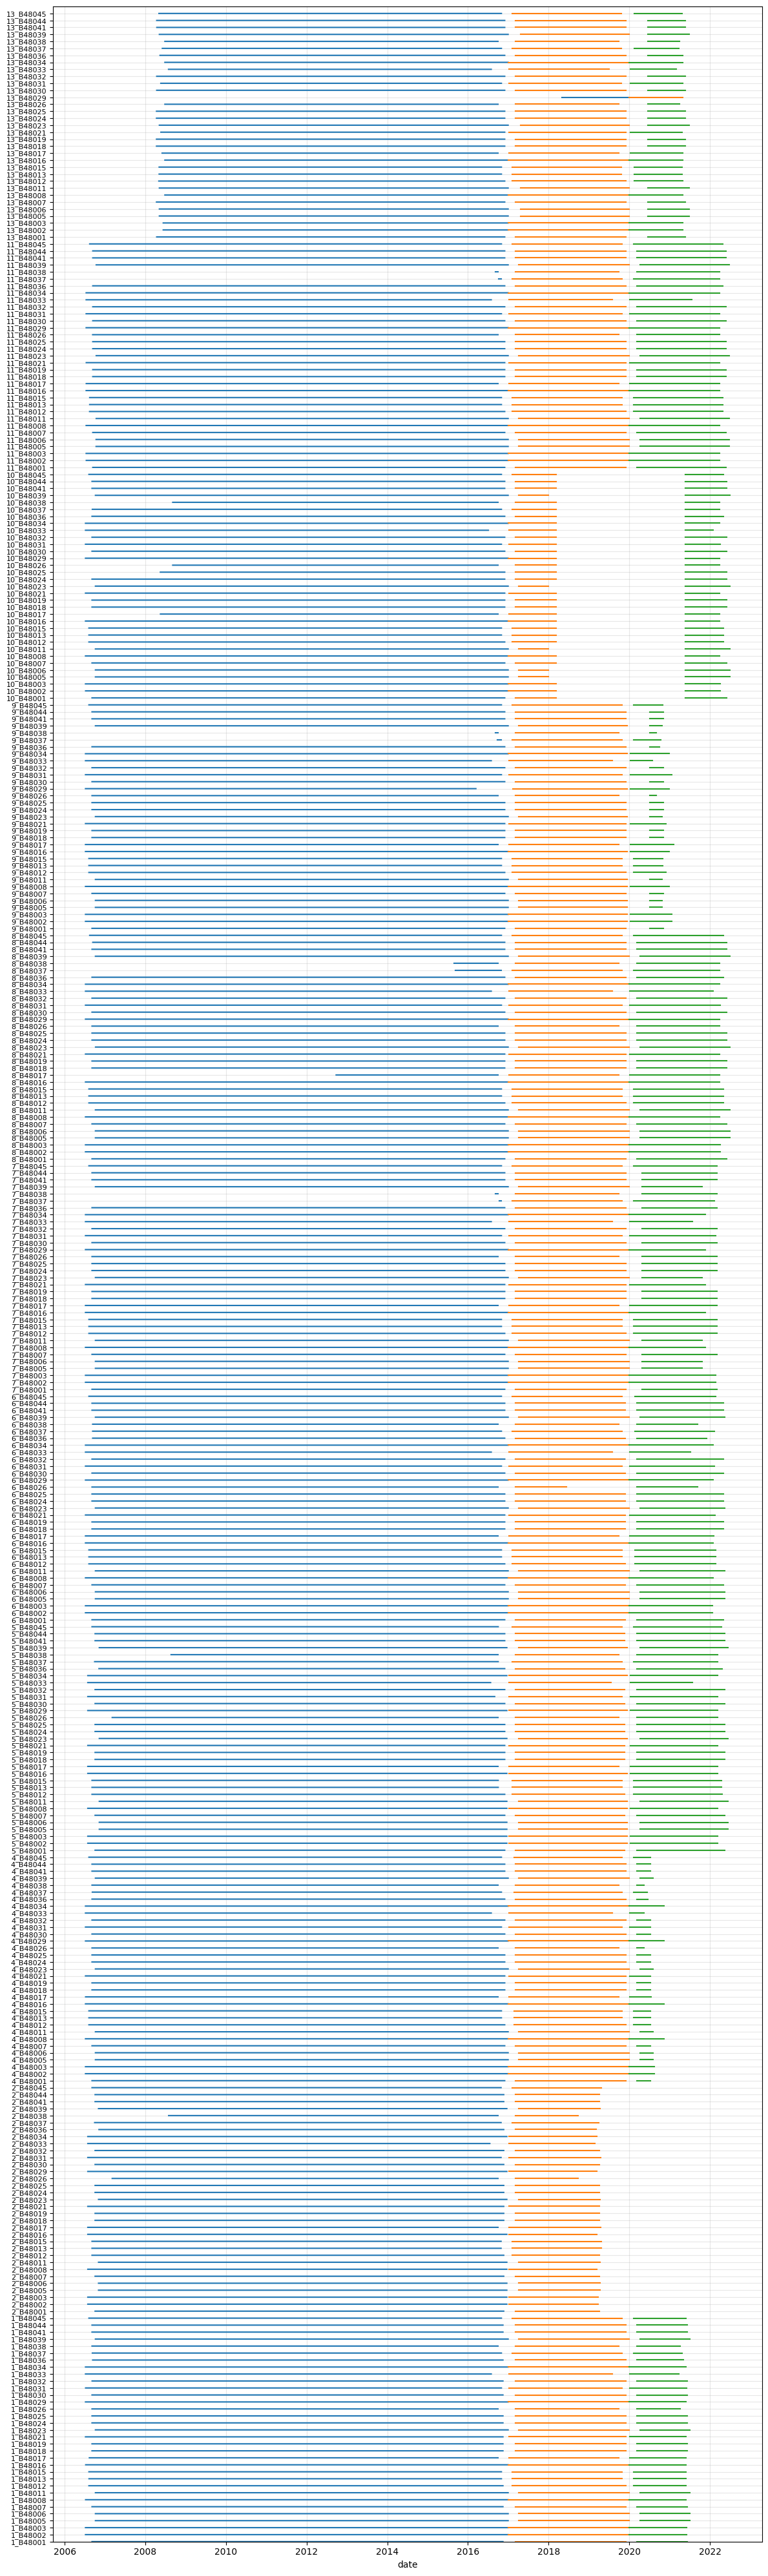

In [30]:
plt.figure(figsize=(12,40))
gids = []
for idx, (_, group) in tqdm(enumerate(df_rolled.groupby(["station_id","pol_var_id"]))):
    gids.append(f"{group.iloc[0].station_id}_{group.iloc[0].pol_var_id}")
    sns.lineplot(x=group.index, y=idx, hue='WHICH', data=group, legend=False)# if idx > 0 else True)

ax = plt.gca()
ax.set_yticks(range(len(gids)))
ax.set_yticklabels(gids, fontsize=8)
# ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
plt.ylim(0, len(gids))
plt.tight_layout()
plt.grid(alpha=.3)
plt.show()

In [31]:
df_rolled[df_rolled.WHICH == "training"].groupby(["station_id", "pol_var_id"]).apply(lambda i: (i.index.min(), i.index.max())).reset_index()

station_id pol_var_id                                           0
0             1     B48001  (2006-09-05 00:00:00, 2016-11-13 00:00:00)
1             1     B48002  (2006-07-08 00:00:00, 2016-12-30 00:00:00)
2             1     B48003  (2006-07-08 00:00:00, 2016-12-30 00:00:00)
3             1     B48005  (2006-10-06 00:00:00, 2016-12-30 00:00:00)
4             1     B48006  (2006-10-06 00:00:00, 2016-12-30 00:00:00)
..          ...        ...                                         ...
357          13     B48038  (2008-06-26 00:00:00, 2016-09-29 00:00:00)
358          13     B48039  (2008-05-07 00:00:00, 2016-12-30 00:00:00)
359          13     B48041  (2008-04-14 00:00:00, 2016-11-29 00:00:00)
360          13     B48044  (2008-04-13 00:00:00, 2016-11-29 00:00:00)
361          13     B48045  (2008-05-03 00:00:00, 2016-10-30 00:00:00)

[362 rows x 3 columns]

In [32]:
df_rolled[df_rolled.WHICH == "validation"].groupby(["station_id", "pol_var_id"]).apply(lambda i: (i.index.min(), i.index.max())).reset_index()

station_id pol_var_id                                           0
0             1     B48001  (2017-03-07 00:00:00, 2019-11-29 00:00:00)
1             1     B48002  (2017-01-01 00:00:00, 2019-12-30 00:00:00)
2             1     B48003  (2017-01-01 00:00:00, 2019-12-30 00:00:00)
3             1     B48005  (2017-04-07 00:00:00, 2019-12-30 00:00:00)
4             1     B48006  (2017-04-07 00:00:00, 2019-12-30 00:00:00)
..          ...        ...                                         ...
358          13     B48038  (2017-03-08 00:00:00, 2019-09-26 00:00:00)
359          13     B48039  (2017-04-20 00:00:00, 2019-12-30 00:00:00)
360          13     B48041  (2017-03-08 00:00:00, 2019-11-29 00:00:00)
361          13     B48044  (2017-03-08 00:00:00, 2019-11-29 00:00:00)
362          13     B48045  (2017-02-07 00:00:00, 2019-10-22 00:00:00)

[363 rows x 3 columns]

In [33]:
df_rolled[df_rolled.WHICH == "test"].groupby(["station_id", "pol_var_id"]).apply(lambda i: (i.index.min(), i.index.max())).reset_index()

station_id pol_var_id                                           0
0             1     B48001  (2020-03-07 00:00:00, 2021-06-08 00:00:00)
1             1     B48002  (2020-01-01 00:00:00, 2021-06-01 00:00:00)
2             1     B48003  (2020-01-01 00:00:00, 2021-06-01 00:00:00)
3             1     B48005  (2020-04-07 00:00:00, 2021-07-01 00:00:00)
4             1     B48006  (2020-04-07 00:00:00, 2021-07-01 00:00:00)
..          ...        ...                                         ...
325          13     B48038  (2020-06-15 00:00:00, 2021-03-31 00:00:00)
326          13     B48039  (2020-06-15 00:00:00, 2021-06-25 00:00:00)
327          13     B48041  (2020-06-15 00:00:00, 2021-05-25 00:00:00)
328          13     B48044  (2020-06-15 00:00:00, 2021-05-25 00:00:00)
329          13     B48045  (2020-02-18 00:00:00, 2021-04-26 00:00:00)

[330 rows x 3 columns]

# 4. Dataset preview

In [34]:
df_rolled[["station_id", "pol_var_id", "pol_value_label", 'pol_value_prev_1', 'pol_value_prev_2', 'pol_value_prev_3',
       'pol_value_prev_4', 'pol_value_prev_5', 'pol_value_prev_6',
       'pol_value_prev_7']].head(10)

station_id pol_var_id  pol_value_label  pol_value_prev_1  \
date                                                                   
2006-09-05           1     B48001             3.01              5.16   
2006-09-06           1     B48001             2.58              3.01   
2006-09-07           1     B48001             2.58              2.58   
2006-09-08           1     B48001             4.30              2.58   
2006-09-09           1     B48001             4.30              4.30   
2006-09-10           1     B48001             5.16              4.30   
2006-09-11           1     B48001             8.17              5.16   
2006-09-12           1     B48001             6.88              8.17   
2006-09-13           1     B48001             6.45              6.88   
2006-09-14           1     B48001             5.16              6.45   

            pol_value_prev_2  pol_value_prev_3  pol_value_prev_4  \
date                                                               
2006-09-05              3.01              3.01              3.87   
2006-09-06              5.16              3.01              3.01   
2006-09-07              3.01              5.16              3.01   
2006-09-08              2.58              3.01              5.16   
2006-09-09              2.58              2.58              3.01   
2006-09-10              4.30              2.58              2.58   
2006-09-11              4.30              4.30              2.58   
2006-09-12              5.16              4.30              4.30   
2006-09-13              8.17              5.16              4.30   
2006-09-14              6.88              8.17              5.16   

            pol_value_prev_5  pol_value_prev_6  pol_value_prev_7  
date                                                              
2006-09-05              5.59              4.73              4.30  
2006-09-06              3.87              5.59              4.73  
2006-09-07              3.01              3.87              5.59  
2006-09-08              3.01              3.01              3.87  
2006-09-09              5.16              3.01              3.01  
2006-09-10              3.01              5.16              3.01  
2006-09-11              2.58              3.01              5.16  
2006-09-12              2.58              2.58              3.01  
2006-09-13              4.30              2.58              2.58  
2006-09-14              4.30              4.30              2.58

In [35]:
df_rolled.describe()

station_id     date_diff  B13011_min_amin  B13011_max_amax  \
count  1.178983e+06  1.178983e+06        1178983.0     1.178983e+06   
mean   6.865375e+00  1.790979e+01              0.0     9.492284e+00   
std    3.502754e+00  1.418035e+01              0.0     1.247705e+01   
min    1.000000e+00  1.000000e+00              0.0     0.000000e+00   
25%    4.000000e+00  8.000000e+00              0.0     2.000000e-01   
50%    7.000000e+00  1.400000e+01              0.0     4.600000e+00   
75%    1.000000e+01  2.400000e+01              0.0     1.420000e+01   
max    1.300000e+01  9.600000e+01              0.0     1.164000e+02   

       B13011_mean_mean  B13011_std_mean  B13011_sum_sum  B14198_min_amin  \
count      1.178983e+06     1.178983e+06    1.178983e+06     1.178983e+06   
mean       5.637511e-02     2.889044e-01    5.706421e+01    -1.114846e+01   
std        7.898944e-02     3.852721e-01    8.039348e+01     3.246445e+00   
min        0.000000e+00     0.000000e+00   -5.684342e-14    -2.000000e+01   
25%        1.344538e-03     9.320997e-03    1.200000e+00    -1.400000e+01   
50%        2.388759e-02     1.356204e-01    2.340000e+01    -1.200000e+01   
75%        8.067227e-02     4.213111e-01    8.140000e+01    -9.000000e+00   
max        7.847059e-01     3.529384e+00    9.338000e+02    -2.000000e+00   

       B14198_max_amax  B14198_mean_mean  ...  pol_var_id_B48032  \
count     1.178983e+06      1.178983e+06  ...       1.178983e+06   
mean      7.730321e+02      1.914252e+02  ...       3.227612e-02   
std       1.913150e+02      8.623004e+01  ...       1.767326e-01   
min       7.500000e+01      8.156905e+00  ...       0.000000e+00   
25%       6.510000e+02      1.193829e+02  ...       0.000000e+00   
50%       8.430000e+02      2.042743e+02  ...       0.000000e+00   
75%       9.250000e+02      2.652400e+02  ...       0.000000e+00   
max       1.084000e+03      3.568651e+02  ...       1.000000e+00   

       pol_var_id_B48033  pol_var_id_B48034  pol_var_id_B48036  \
count       1.178983e+06       1.178983e+06       1.178983e+06   
mean        2.408262e-02       3.157806e-02       2.729641e-02   
std         1.533058e-01       1.748740e-01       1.629458e-01   
min         0.000000e+00       0.000000e+00       0.000000e+00   
25%         0.000000e+00       0.000000e+00       0.000000e+00   
50%         0.000000e+00       0.000000e+00       0.000000e+00   
75%         0.000000e+00       0.000000e+00       0.000000e+00   
max         1.000000e+00       1.000000e+00       1.000000e+00   

       pol_var_id_B48037  pol_var_id_B48038  pol_var_id_B48039  \
count       1.178983e+06       1.178983e+06       1.178983e+06   
mean        1.983404e-02       1.674579e-02       3.191055e-02   
std         1.394298e-01       1.283175e-01       1.757620e-01   
min         0.000000e+00       0.000000e+00       0.000000e+00   
25%         0.000000e+00       0.000000e+00       0.000000e+00   
50%         0.000000e+00       0.000000e+00       0.000000e+00   
75%         0.000000e+00       0.000000e+00       0.000000e+00   
max         1.000000e+00       1.000000e+00       1.000000e+00   

       pol_var_id_B48041  pol_var_id_B48044  pol_var_id_B48045  
count       1.178983e+06       1.178983e+06       1.178983e+06  
mean        3.209970e-02       3.227443e-02       3.209291e-02  
std         1.762650e-01       1.767281e-01       1.762469e-01  
min         0.000000e+00       0.000000e+00       0.000000e+00  
25%         0.000000e+00       0.000000e+00       0.000000e+00  
50%         0.000000e+00       0.000000e+00       0.000000e+00  
75%         0.000000e+00       0.000000e+00       0.000000e+00  
max         1.000000e+00       1.000000e+00       1.000000e+00  

[8 rows x 97 columns]

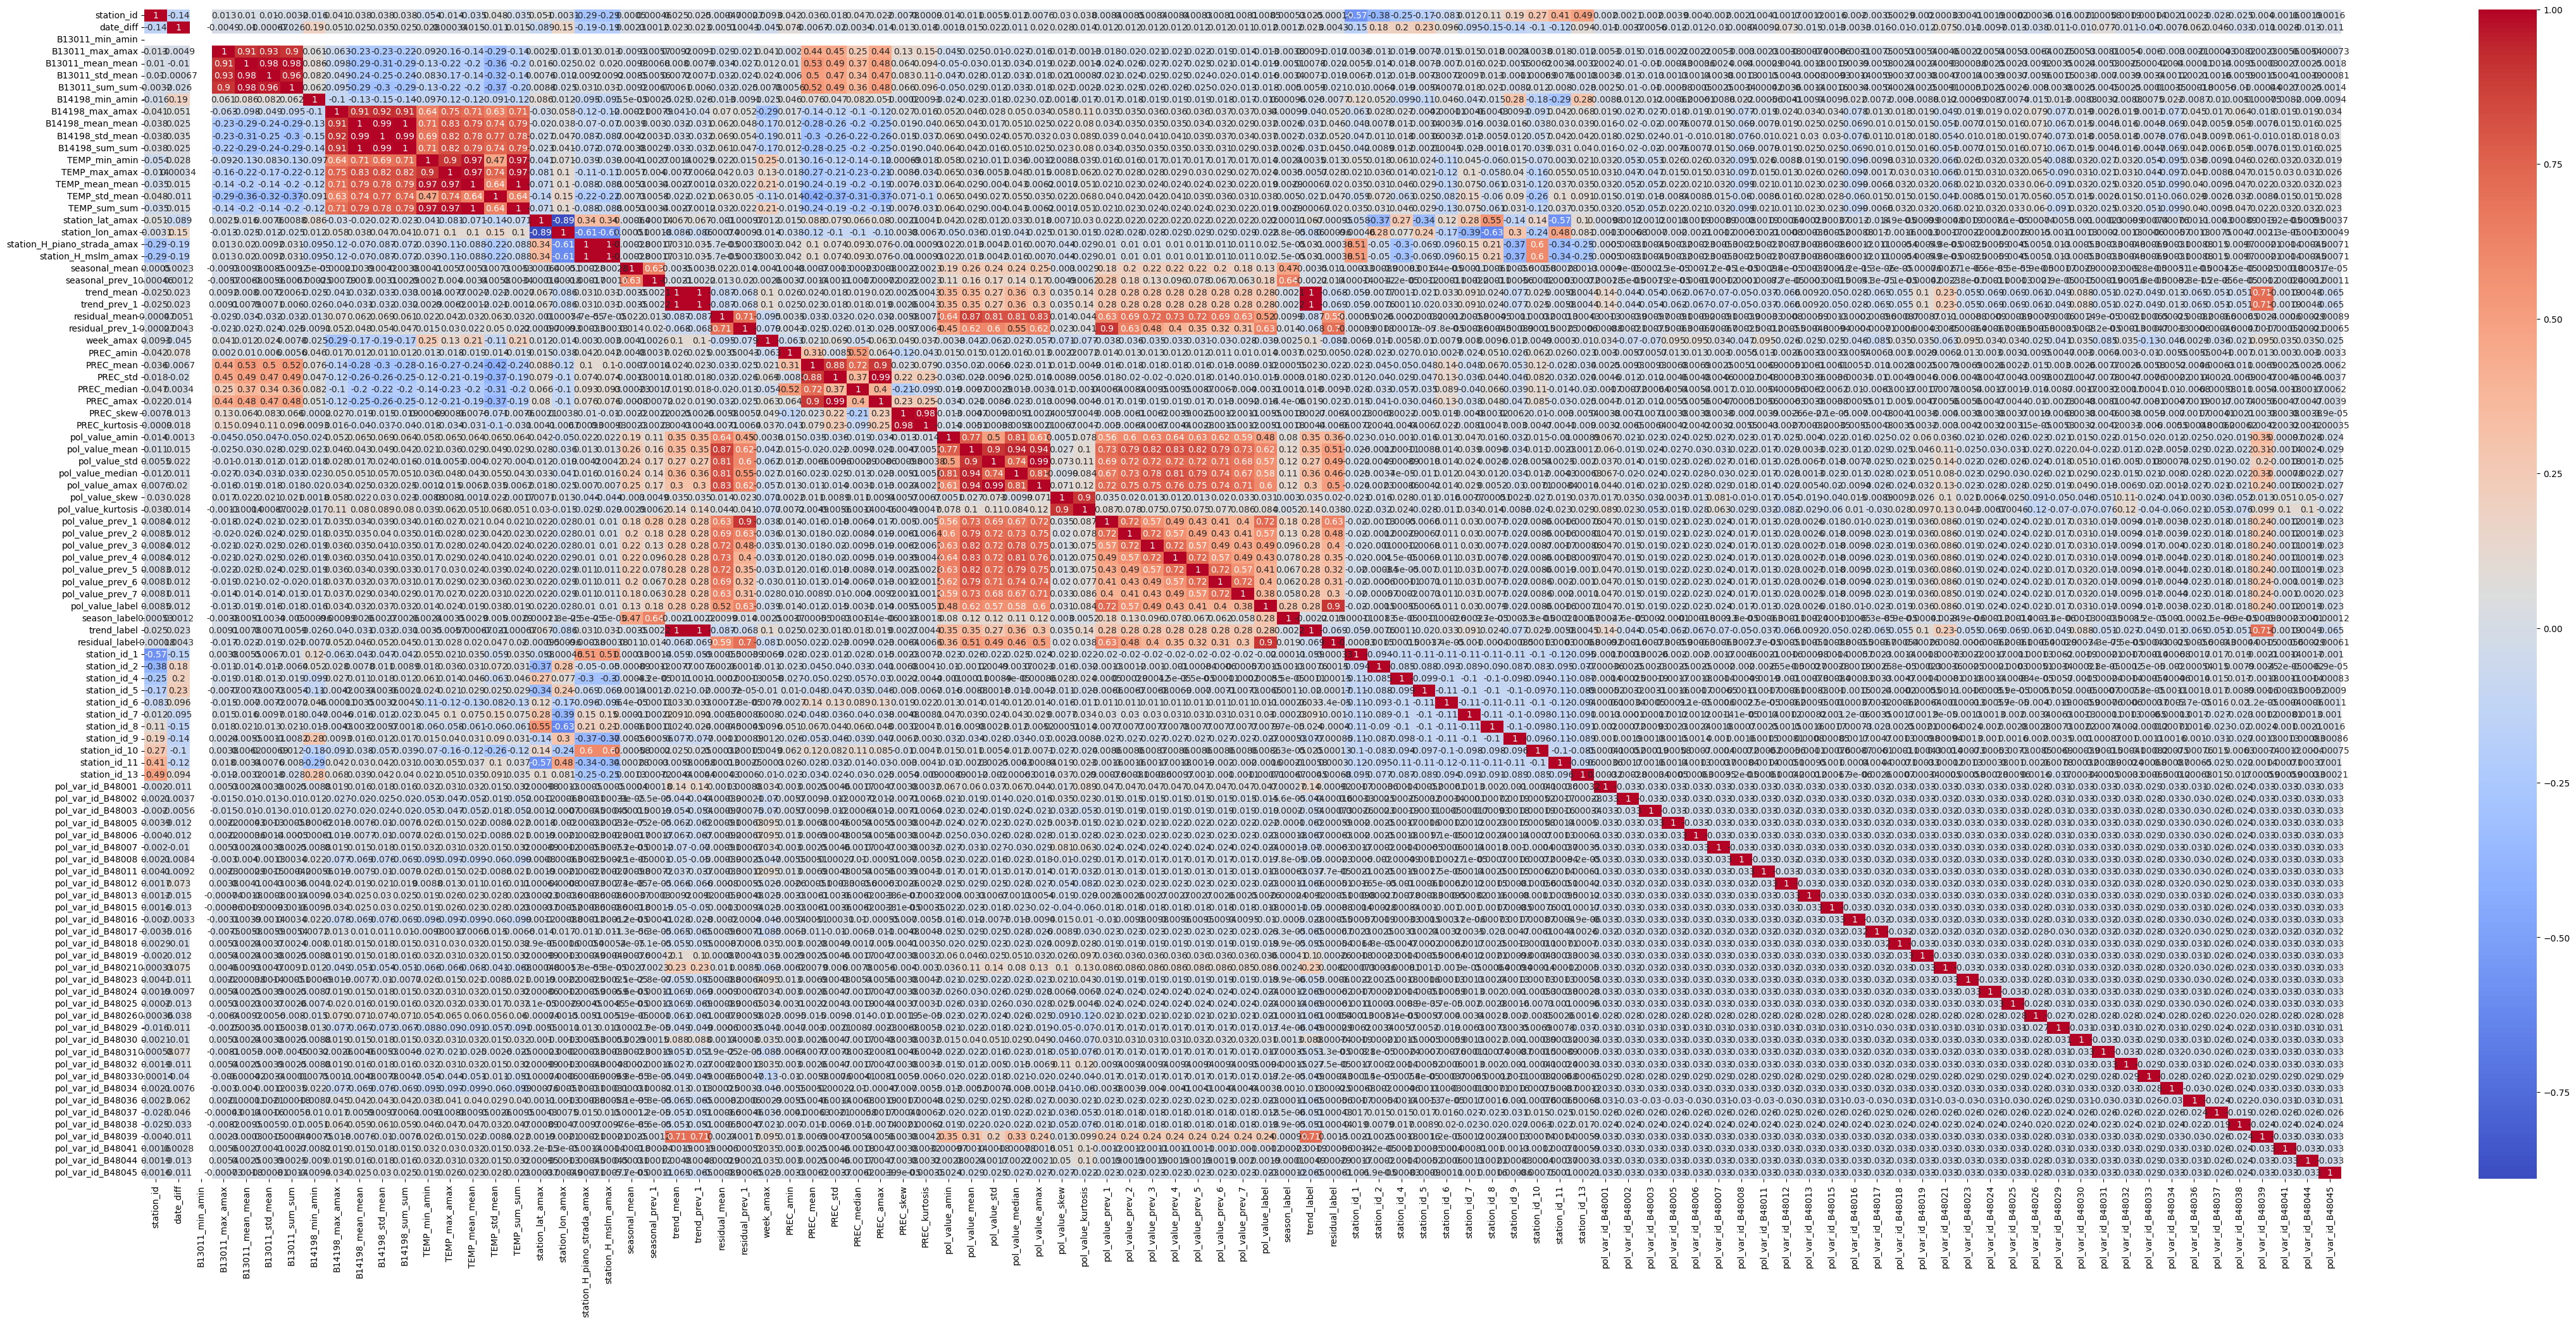

In [36]:
corr_matrix = df_rolled.corr()
plt.figure(figsize=(56,24))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True);

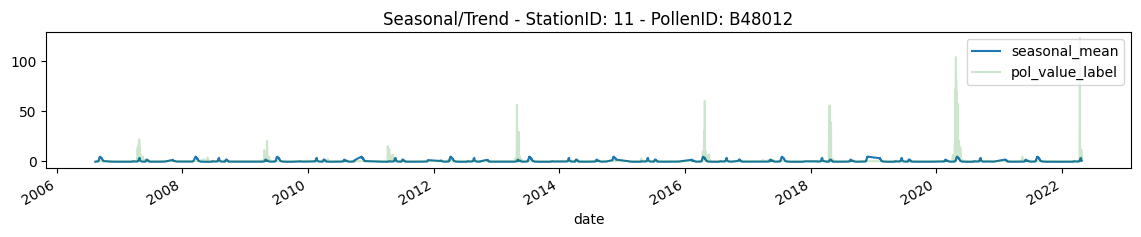

In [37]:
### Verify features
tmp_stid, tmp_polid = df_rolled.sample(1).iloc[0][["station_id", "pol_var_id"]].values
tmp_df = df_rolled[(df_rolled.station_id==tmp_stid) & (df_rolled.pol_var_id==tmp_polid)].copy()
# tmp_df.set_index("date", inplace=True)

plt.figure(figsize=(14,2))
plt.title(f"Seasonal/Trend - StationID: {tmp_stid} - PollenID: {tmp_polid}")
tmp_df.seasonal_mean.plot()
# tmp_df.pol_value_label.plot(alpha=.2)
# tmp_df.PREC_skew.plot()
tmp_df.pol_value_label.plot(c="green", alpha=.2)
plt.legend(loc="upper right");

# 5. Store dataset in feather format

In [ ]:
df_rolled.reset_index(inplace=True)
df_rolled.to_feather(f"data/dataset_{window_day_size}D.feather")

## Store dataset in BigQuery Table

In [42]:
df_rolled.to_gbq("JOINED_DATA.SLIDING_WINDOWS_DATASET", project_id="arpae-prod-ml", if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 4328.49it/s]


# 6. Normalize and store dataset in feather format

In [43]:
features_plain = [
    'B13011_min_amin', 'B13011_max_amax', 'B13011_mean_mean', 'B13011_std_mean',
    'B13011_sum_sum', 'B14198_min_amin', 'B14198_max_amax',
    'B14198_mean_mean', 'B14198_std_mean', 'B14198_sum_sum',
    'TEMP_min_amin', 'TEMP_max_amax', 'TEMP_mean_mean', 'TEMP_std_mean',
    'TEMP_sum_sum', 'station_lat_amax', 'station_lon_amax',
    'station_H_piano_strada_amax', 'station_H_mslm_amax', 'week_amax', 'PREC_amin', 'PREC_mean', 'PREC_std',
    'PREC_median', 'PREC_amax', 'PREC_skew', 'PREC_kurtosis',
]

features_paired = [
    'pol_value_amin', 'pol_value_mean', 'pol_value_std', 'pol_value_median',
    'pol_value_amax', 'pol_value_skew', 'pol_value_kurtosis',
    'pol_value_prev_1', 'pol_value_prev_2', 'pol_value_prev_3',
    'pol_value_prev_4', 'pol_value_prev_5', 'pol_value_prev_6',
    'pol_value_prev_7', 'pol_value_label',
    'seasonal_mean', 'season_label', 'seasonal_prev_1',
    'trend_label', 'trend_mean', 'trend_prev_1',
    'residual_label', 'residual_mean', 'residual_prev_1'
]

### Normalize station/specie features

In [44]:
# Groupby 'station_id' and 'pol_var_id' columns
df_normalized = df_rolled.copy()
df_normalized.date = pd.to_datetime(df_normalized.date)
df_normalized.set_index("date", inplace=True)
df_grouped = df_normalized.groupby(['station_id', 'pol_var_id'])

### Normalize every column with MinMaxScaler

In [45]:
scaler = MinMaxScaler()
df_normalized[features_paired] = df_grouped[features_paired].progress_apply(lambda x: pd.DataFrame(scaler.fit_transform(x), columns=x.columns)).values

  0%|          | 0/363 [00:00<?, ?it/s]

### Normalize global features

In [46]:
df_normalized[features_plain] = scaler.fit_transform(df_normalized[features_plain])

In [47]:
print(df_normalized.shape)
display(df_normalized.describe())

(1178983, 99)


station_id     date_diff  B13011_min_amin  B13011_max_amax  \
count  1.178983e+06  1.178983e+06        1178983.0     1.178983e+06   
mean   6.865375e+00  1.790979e+01              0.0     8.154883e-02   
std    3.502754e+00  1.418035e+01              0.0     1.071912e-01   
min    1.000000e+00  1.000000e+00              0.0     0.000000e+00   
25%    4.000000e+00  8.000000e+00              0.0     1.718213e-03   
50%    7.000000e+00  1.400000e+01              0.0     3.951890e-02   
75%    1.000000e+01  2.400000e+01              0.0     1.219931e-01   
max    1.300000e+01  9.600000e+01              0.0     1.000000e+00   

       B13011_mean_mean  B13011_std_mean  B13011_sum_sum  B14198_min_amin  \
count      1.178983e+06     1.178983e+06    1.178983e+06     1.178983e+06   
mean       7.184234e-02     8.185689e-02    6.110967e-02     4.917524e-01   
std        1.006612e-01     1.091613e-01    8.609282e-02     1.803581e-01   
min        0.000000e+00     0.000000e+00    0.000000e+00     0.000000e+00   
25%        1.713429e-03     2.640970e-03    1.285072e-03     3.333333e-01   
50%        3.044145e-02     3.842608e-02    2.505890e-02     4.444444e-01   
75%        1.028057e-01     1.193724e-01    8.717070e-02     6.111111e-01   
max        1.000000e+00     1.000000e+00    1.000000e+00     1.000000e+00   

       B14198_max_amax  B14198_mean_mean  ...  pol_var_id_B48032  \
count     1.178983e+06      1.178983e+06  ...       1.178983e+06   
mean      6.918059e-01      5.255634e-01  ...       3.227612e-02   
std       1.896085e-01      2.472842e-01  ...       1.767326e-01   
min       0.000000e+00      0.000000e+00  ...       0.000000e+00   
25%       5.708622e-01      3.189657e-01  ...       0.000000e+00   
50%       7.611497e-01      5.624111e-01  ...       0.000000e+00   
75%       8.424182e-01      7.372441e-01  ...       0.000000e+00   
max       1.000000e+00      1.000000e+00  ...       1.000000e+00   

       pol_var_id_B48033  pol_var_id_B48034  pol_var_id_B48036  \
count       1.178983e+06       1.178983e+06       1.178983e+06   
mean        2.408262e-02       3.157806e-02       2.729641e-02   
std         1.533058e-01       1.748740e-01       1.629458e-01   
min         0.000000e+00       0.000000e+00       0.000000e+00   
25%         0.000000e+00       0.000000e+00       0.000000e+00   
50%         0.000000e+00       0.000000e+00       0.000000e+00   
75%         0.000000e+00       0.000000e+00       0.000000e+00   
max         1.000000e+00       1.000000e+00       1.000000e+00   

       pol_var_id_B48037  pol_var_id_B48038  pol_var_id_B48039  \
count       1.178983e+06       1.178983e+06       1.178983e+06   
mean        1.983404e-02       1.674579e-02       3.191055e-02   
std         1.394298e-01       1.283175e-01       1.757620e-01   
min         0.000000e+00       0.000000e+00       0.000000e+00   
25%         0.000000e+00       0.000000e+00       0.000000e+00   
50%         0.000000e+00       0.000000e+00       0.000000e+00   
75%         0.000000e+00       0.000000e+00       0.000000e+00   
max         1.000000e+00       1.000000e+00       1.000000e+00   

       pol_var_id_B48041  pol_var_id_B48044  pol_var_id_B48045  
count       1.178983e+06       1.178983e+06       1.178983e+06  
mean        3.209970e-02       3.227443e-02       3.209291e-02  
std         1.762650e-01       1.767281e-01       1.762469e-01  
min         0.000000e+00       0.000000e+00       0.000000e+00  
25%         0.000000e+00       0.000000e+00       0.000000e+00  
50%         0.000000e+00       0.000000e+00       0.000000e+00  
75%         0.000000e+00       0.000000e+00       0.000000e+00  
max         1.000000e+00       1.000000e+00       1.000000e+00  

[8 rows x 97 columns]

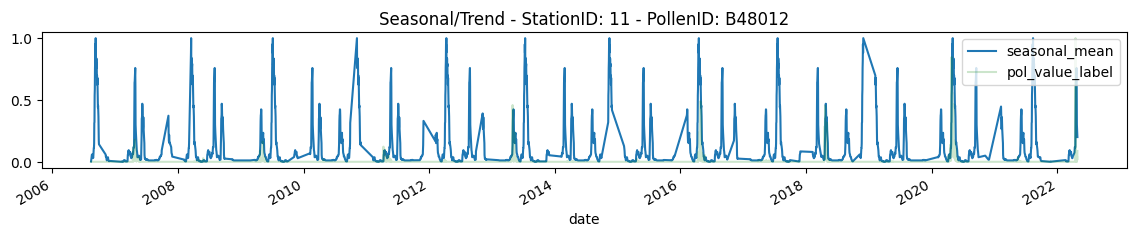

In [48]:
### Verify features
# tmp_stid, tmp_polid = df_rolled.sample(1).iloc[0][["station_id", "pol_var_id"]].values
tmp_df = df_normalized[(df_normalized.station_id==tmp_stid) & (df_normalized.pol_var_id==tmp_polid)].copy()
# tmp_df.set_index("date", inplace=True)

plt.figure(figsize=(14,2))
plt.title(f"Seasonal/Trend - StationID: {tmp_stid} - PollenID: {tmp_polid}")
tmp_df.seasonal_mean.plot()
# tmp_df.pol_value_label.plot(alpha=.2)
# tmp_df.PREC_skew.plot()
tmp_df.pol_value_label.plot(c="green", alpha=.2)
plt.legend(loc="upper right");

### Store to file

In [114]:
df_normalized.reset_index(inplace=True)
df_normalized.to_feather(f"data/dataset_{window_day_size}D_normalized.feather")